In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from jupyterthemes import jtplot
jtplot.style(theme="monokai", context="notebook", ticks=True)

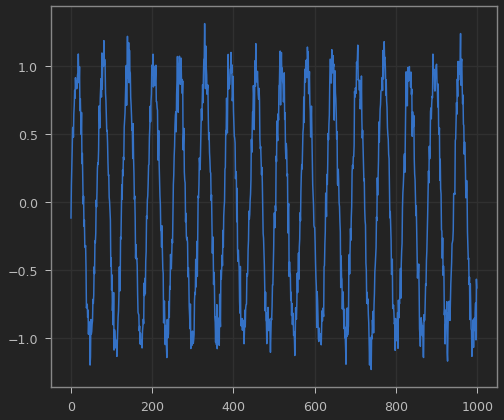

In [2]:
# Create the original data
N = 1000
series = np.sin(0.1*np.arange(N)) + np.random.randn(N) * 0.1

plt.plot(series)
plt.show()

In [3]:
# Build the datasets
T = 10
X = []
Y = []

for t in range(len(series) - T):
    x = series[t : t + T]
    X.append(x)
    
    y = series[t+T]
    Y.append(y)
    
    
X = np.asarray(X)
Y = np.asarray(Y)
X = X.reshape(-1, T)
Y = Y.reshape(-1, 1)
N = len(X)
print("Shape of X : {} || Y : {}".format(X.shape, Y.shape))

Shape of X : (990, 10) || Y : (990, 1)


In [4]:
## Build the autoregressive model
model = nn.Linear(T, 1)

In [5]:
# Define the Loss and Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [6]:
# Make train and test set
Xtrain = torch.from_numpy(X[:-N//2].astype(np.float32))
Ytrain = torch.from_numpy(Y[:-N//2].astype(np.float32))

Xtest = torch.from_numpy(X[-N//2:].astype(np.float32))
Ytest = torch.from_numpy(Y[-N//2:].astype(np.float32))


In [7]:
def full_gd(model, criterion, optimizer, Xtrain, Ytrain, Xtest, Ytest, epochs=100):
    
    train_losses = np.zeros(Xtrain.shape[0])
    test_losses = np.zeros(Xtest.shape[0])
    
    for epoch in range(epochs):
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward propagate
        outputs = model(Xtrain)
        loss = criterion(outputs, Ytrain)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        # Track the loss
        train_losses[epoch] = loss.item()
        
        # Forward propagate test data
        testoutputs = model(Xtest)
        testloss = criterion(testoutputs, Ytest)
        
        # Track test losses
        test_losses[epoch] = testloss.item()
        
        
        print("Epoch : {}/{} || Train Loss : {:.4f} Test Loss : {:.4f}".format(epoch+1,
                                                                           epochs,
                                                                           train_losses[epoch],
                                                                           test_losses[epoch]))
        
    return train_losses, test_losses

In [8]:
train_losses, test_losses = full_gd(model, criterion, optimizer, Xtrain, Ytrain, 
                                   Xtest, Ytest, epochs=200)

Epoch : 1/200 || Train Loss : 0.6395 Test Loss : 0.1845
Epoch : 2/200 || Train Loss : 0.1769 Test Loss : 0.3462
Epoch : 3/200 || Train Loss : 0.3428 Test Loss : 0.3608
Epoch : 4/200 || Train Loss : 0.3587 Test Loss : 0.2086
Epoch : 5/200 || Train Loss : 0.2060 Test Loss : 0.0867
Epoch : 6/200 || Train Loss : 0.0828 Test Loss : 0.0802
Epoch : 7/200 || Train Loss : 0.0753 Test Loss : 0.1334
Epoch : 8/200 || Train Loss : 0.1288 Test Loss : 0.1476
Epoch : 9/200 || Train Loss : 0.1443 Test Loss : 0.1008
Epoch : 10/200 || Train Loss : 0.0985 Test Loss : 0.0405
Epoch : 11/200 || Train Loss : 0.0386 Test Loss : 0.0178
Epoch : 12/200 || Train Loss : 0.0159 Test Loss : 0.0411
Epoch : 13/200 || Train Loss : 0.0390 Test Loss : 0.0747
Epoch : 14/200 || Train Loss : 0.0725 Test Loss : 0.0817
Epoch : 15/200 || Train Loss : 0.0793 Test Loss : 0.0598
Epoch : 16/200 || Train Loss : 0.0574 Test Loss : 0.0348
Epoch : 17/200 || Train Loss : 0.0327 Test Loss : 0.0302
Epoch : 18/200 || Train Loss : 0.0287 Te

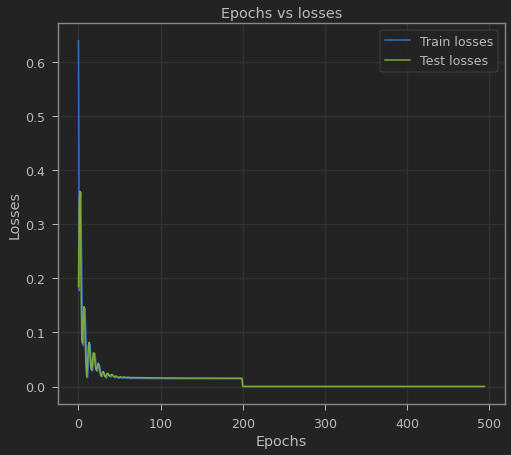

In [9]:
plt.title("Epochs vs losses")
plt.plot(train_losses, label = "Train losses")
plt.plot(test_losses, label = "Test losses")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend()
plt.show()

In [10]:
# Forecast future values
validation_target = Y[-N//2:]
validation_predictions = []

last_x = torch.from_numpy(X[-N//2].astype(np.float32))

while len(validation_predictions) < len(validation_target):
    
    input_ = last_x.view(1, -1)
    p = model(input_)
    
    validation_predictions.append(p[0, 0].item())
    
    # make the new input
    last_x = torch.cat((last_x[1:], p[0]))

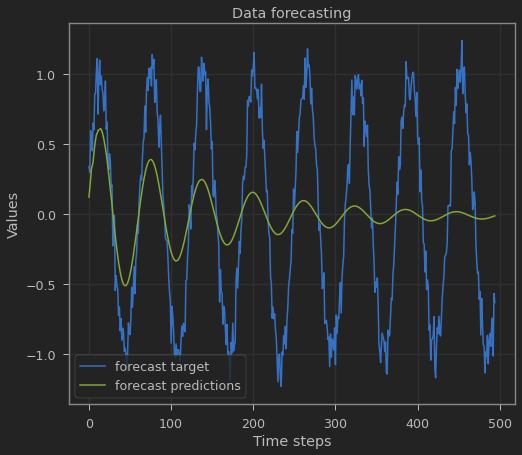

In [11]:
plt.title("Data forecasting")
plt.plot(validation_target, label="forecast target")
plt.plot(validation_predictions, label="forecast predictions")
plt.xlabel("Time steps")
plt.ylabel("Values")
plt.legend()
plt.show()